# We need to count the edits across 3'UTRs to compare bulk data to single cell.
- Just like for single cell and aggr, we're converting edit BED files to BAM files and using those as inputs to featureCounts. 
- Using 10X three_prime_utr annotations, generate a SAF file using just 3'UTRs and count edits along these regions only.
- Just so we have everything, we're counting edits in every single dataset, resulting in a single counts.txt file.

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import glob
import os
import numpy as np
import pandas as pd
import gffutils
import pysam
import pybedtools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import OrderedDict
from tqdm import tnrange, tqdm_notebook

pd.set_option('display.max_columns', 150)

In [2]:
conf = 0.9

In [3]:
input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/edit_featurecounts{}'.format(conf)
tmp_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/edit_featurecounts{}/tmp'.format(conf)

# These settings control various notebook parameters
- conf: if we want to filter out edits that fall below this conf score
- suffix: this appends either '.noApo' to our output filenames or nothing. Change this param depending on whether or not we want to remove ApoControl-1000 sites.
- apo1000: filepath of the BED6 edit calls from control sample to filter out

In [4]:
suffix = ''
# suffix = '.noApo' # or empty string '' if we don't want to remove the Apo1000 data.
apo1000 = os.path.join(input_dir, 'ApoControl-1000_S21_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.bed')

In [5]:
all_bed_files = sorted(glob.glob(os.path.join(input_dir, '*.bed')))
print(len(all_bed_files))
all_bed_files[:3]

182


['/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/ABCE1-0_S1_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.bed',
 '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/ABCE1-1000_S15_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.bed',
 '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/ABCE1-1000_S15_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.noRmDup.bed']

In [6]:
def filter_bed(input_bed, output_bed, conf, suffix, bg=apo1000):
    """
    Filters the BED file 
    
    input_bed, output_bed: paths to the BED6 file containing edit calls (conf scores MUST be in the 4th column!)
    conf: confidence filter
    suffix: if '.noApo' (needs the dot), this parameter triggers an additional filter (bedtools intersect -v) to remove sites 
    bg: filepath to the edits to be filtered.
    """
    try:
        edit_head = ['chrom','start','end','conf','frac','strand']
        df = pd.read_csv(input_bed, names=edit_head, sep='\t')
        prev_shape = df.shape[0]
        df = df[df['conf']>=conf]
        if suffix == '.noApo':
            pre_filtered = pybedtools.BedTool.from_dataframe(df).sort()
            apo_control = pybedtools.BedTool(bg).sort()
            post_filtered = pre_filtered.intersect(apo_control, v=True, s=True)
            df = post_filtered.to_dataframe()
        print("{} Apo filtering: {} -> {}".format(os.path.basename(input_bed).replace('.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted',''), prev_shape, df.shape[0]))
        df.to_csv(output_bed, sep='\t', header=False, index=False)
    except Exception as e:
        print(e)

# Basically filter for conf, perform bedToBam and samtools sort on these guys.

In [7]:
genome = '/projects/ps-yeolab3/bay001/annotations/hg19/hg19.chrom.sizes'
progress = tnrange(len(all_bed_files))
for bed in all_bed_files:
    output_bam = os.path.join(tmp_dir, os.path.basename(bed).replace('.bed','{}.bam'.format(suffix)))
    output_sorted_bam = os.path.join(tmp_dir, os.path.basename(bed).replace('.bed','{}.sorted.bam'.format(suffix)))
    filter_fn = os.path.join(tmp_dir, os.path.basename(bed) + ".{}{}.bed".format(conf, suffix))
    
    filter_bed(bed, filter_fn, conf, suffix)
    cmd = 'bedToBam '
    cmd += '-i {} '.format(filter_fn)
    cmd += '-g {} '.format(genome)
    cmd += '> {}'.format(output_bam)
    ! $cmd
    sort_cmd = 'samtools sort {} > {}'.format(output_bam, output_sorted_bam)
    ! $sort_cmd
    progress.update(1)

ABCE1-0_S1_L001_R1_001_a0_b0_e0.01.bed Apo filtering: 27235 -> 8240
ABCE1-1000_S15_L002_R1_001_a0_b0_e0.01.bed Apo filtering: 55322 -> 17077
ABCE1-1000_S15_L002_R1_001_a0_b0_e0.01.noRmDup.bed Apo filtering: 143931 -> 22201
ABCE1-50_S8_L001_R1_001_a0_b0_e0.01.bed Apo filtering: 35846 -> 10681
APOBEC-only_a0_b0_e0.01.bed Apo filtering: 831149 -> 290075
APOBEC_only_0_merged_R1_a0_b0_e0.01.bed Apo filtering: 42044 -> 18828
APOBEC_only_1000_merged_R1_a0_b0_e0.01.bed Apo filtering: 58761 -> 30055
APOBEC_only_1000_merged_R1_a0_b0_e0.01.noRmDup.bed Apo filtering: 140507 -> 33802
APOBEC_only_50_merged_R1_a0_b0_e0.01.bed Apo filtering: 39154 -> 19718
ApoControl-0_S7_L001_R1_001_a0_b0_e0.01.bed Apo filtering: 37342 -> 10442
ApoControl-0_S7_L001_R1_001_a0_b0_e0.01.noRmDup.bed Apo filtering: 100508 -> 14128
ApoControl-1000_S21_L002_R1_001.21M_a0_b0_e0.01.bed Apo filtering: 35228 -> 12996
ApoControl-1000_S21_L002_R1_001_a0_b0_e0.01.bed Apo filtering: 66380 -> 20550
ApoControl-1000_S21_L002_R1_001_a0

# Run featureCounts 
- Note: -s 1 for stranded even though the reads are reverse-stranded, the edits should be on the correct strand.

In [8]:
gtf = '/projects/ps-yeolab3/bay001/annotations/hg19/gencode_v19/gencode.v19.annotation.gtf'

cmd = 'module load subreadfeaturecounts;featureCounts '
cmd += '-a {} '.format(gtf)
cmd += '-s 1 '
cmd += '-o {}'.format(os.path.join(output_dir, 'counts_at_conf_{}{}.txt '.format(conf, suffix)))
cmd += '-R CORE '
cmd += os.path.join(tmp_dir, '*{}.sorted.bam'.format(suffix))

print("writing to: {}".format(os.path.join(output_dir, 'counts_at_conf_{}{}.txt '.format(conf, suffix))))

! $cmd

writing to: /home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/edit_featurecounts0.9/counts_at_conf_0.9.txt 

        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v1.5.3

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 182 BAM files                                    ||
||                           S /home/bay001/projects/kris_apobec_20200121 ... ||
||                           S /home/bay001/projects/kris_apobec_2

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


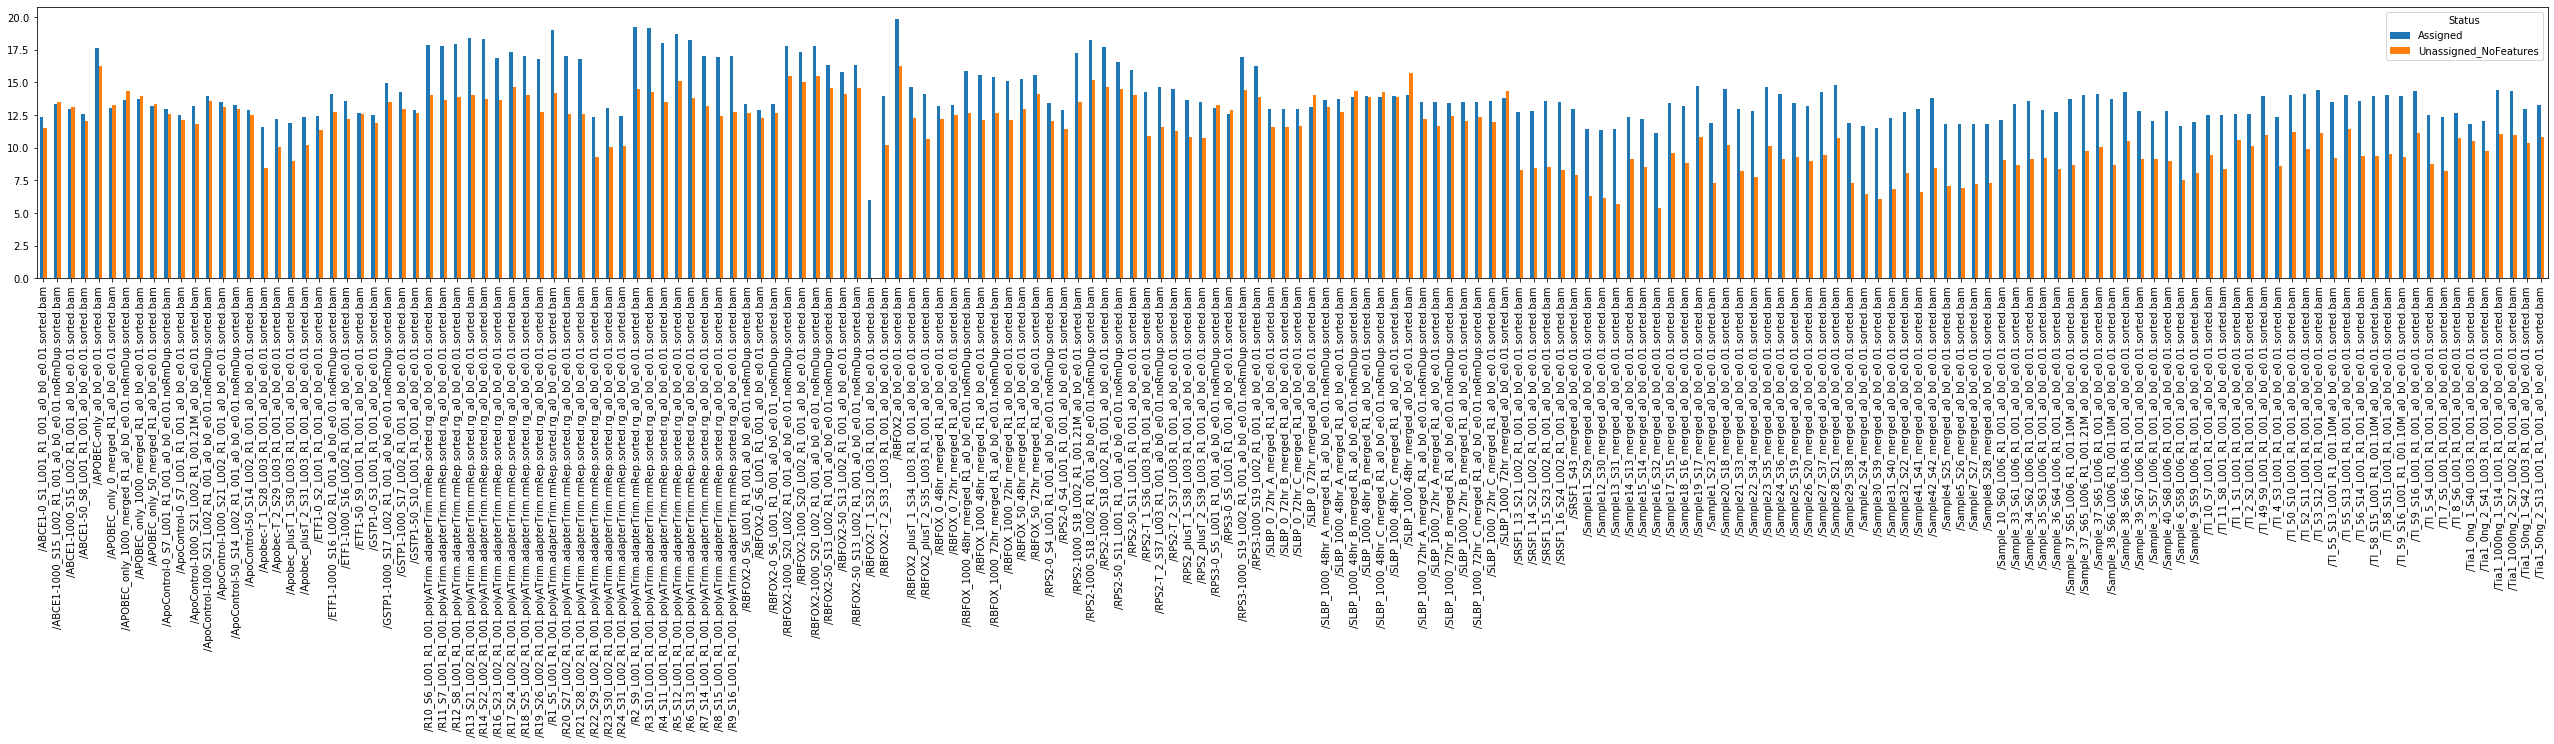

In [9]:
fig, ax = plt.subplots(figsize=(45, 5))
df = pd.read_csv(os.path.join(output_dir, 'counts_at_conf_{}.txt.summary'.format(conf)), sep='\t', index_col=0)
df.columns = [c.replace(tmp_dir, '').replace('.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted','') for c in df.columns]
np.log2(df).T[['Assigned','Unassigned_NoFeatures']].plot(kind='bar', ax=ax)

# Let's run featureCounts using just the CDS, in addition to the whole gene.
- Now we're using 10X annotations so it'll be easier to compare to sc data.
- Just so I don't have to keep checking this, the sc notebook pulls data from the 'lenti-common' gtf, which is different from the below reference by only one line (the lenti common contig). The 3'UTRs are exactly the same.
- this is in rebuttal for RPS STAMP sc vs bulk comparisons. Compare the CDS

#### Simply grep for 'CDS' tab from GTF file to get all CDS annotations.

In [10]:
gtf = '/projects/ps-yeolab4/NCRCRG/refs/refdata-cellranger-hg19-3.0.0/genes/genes.gtf'
gtf_cds_file = os.path.join(tmp_dir, 'genes.cds.gtf')

! grep --color -P '\tCDS\t' $gtf > $gtf_cds_file

#### Now re-format gtf-formatted file into an SAF-formatted file. 

In [11]:
gtf_cds = pd.read_csv(gtf_cds_file, names=['chrom','src','region','start','end','.','strand','.','attr'], sep='\t')
gtf_cds['geneid'] = gtf_cds['attr'].str.extract("gene_id \"([\w\d\.]+)\"")
gtf_cds['chromfx'] = 'chr' + gtf_cds['chrom'].astype(str)
gtf_cds = gtf_cds[['geneid','chromfx','start','end','strand']]
gtf_cds.head()

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)
/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,geneid,chromfx,start,end,strand
0,ENSG00000186092,chr1,69091,70005,+
1,ENSG00000237683,chr1,138533,139309,-
2,ENSG00000235249,chr1,367659,368594,+
3,ENSG00000185097,chr1,621099,622034,-
4,ENSG00000269831,chr1,739121,739137,-


In [12]:
gtf_cds.to_csv(
    os.path.join(tmp_dir, 'genes.cds_only.SAF'),
    sep='\t',
    index=False,
    header=False
)

In [13]:
saf = os.path.join(tmp_dir, 'genes.cds_only.SAF')

#### Run featureCounts using the SAF file that was creating from just the CDS.

In [14]:
cmd = 'module load subreadfeaturecounts;featureCounts '
cmd += '-a {} '.format(saf)
cmd += '-F SAF '
cmd += '-s 1 '
cmd += '-o {}'.format(os.path.join(output_dir, 'counts_at_conf_{}{}.cds.txt '.format(conf, suffix)))
cmd += '-R CORE '
cmd += os.path.join(tmp_dir, '*{}.sorted.bam'.format(suffix))

print("writing to: {}".format(os.path.join(output_dir, 'counts_at_conf_{}{}.cds.txt '.format(conf, suffix))))

! $cmd

writing to: /home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/edit_featurecounts0.9/counts_at_conf_0.9.cds.txt 

        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v1.5.3

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 182 BAM files                                    ||
||                           S /home/bay001/projects/kris_apobec_20200121 ... ||
||                           S /home/bay001/projects/kris_apob

# Let's run featureCounts using 3utrs also, in addition to the whole gene.
- Now we're using 10X annotations so it'll be easier to compare to sc data.
- Just so I don't have to keep checking this, the sc notebook pulls data from the 'lenti-common' gtf, which is different from the below reference by only one line (the lenti common contig). The 3'UTRs are exactly the same.
- 

In [15]:
gtf = '/projects/ps-yeolab4/NCRCRG/refs/refdata-cellranger-hg19-3.0.0/genes/genes.gtf'
gtf_3utr_file = os.path.join(tmp_dir, 'genes.three_prime_utr_only.gtf')

! grep --color 'three_prime_utr' $gtf > $gtf_3utr_file

In [16]:
gtf_3utr = pd.read_csv(gtf_3utr_file, names=['chrom','src','region','start','end','.','strand','.','attr'], sep='\t')
gtf_3utr['geneid'] = gtf_3utr['attr'].str.extract("gene_id \"([\w\d\.]+)\"")
gtf_3utr['chromfx'] = 'chr' + gtf_3utr['chrom']
gtf_3utr = gtf_3utr[['geneid','chromfx','start','end','strand']]
gtf_3utr.head()

,geneid,chromfx,start,end,strand
0,ENSG00000237683,chr1,137621,138529,-
1,ENSG00000237683,chr1,134901,135802,-
2,ENSG00000235249,chr1,368598,368634,+
3,ENSG00000185097,chr1,621059,621095,-
4,ENSG00000187634,chr1,879534,879955,+


In [17]:
gtf_3utr.to_csv(
    os.path.join(tmp_dir, 'genes.three_prime_utr_only.SAF'),
    sep='\t',
    index=False,
    header=False
)

In [18]:
saf = os.path.join(tmp_dir, 'genes.three_prime_utr_only.SAF')

In [19]:
cmd = 'module load subreadfeaturecounts;featureCounts '
cmd += '-a {} '.format(saf)
cmd += '-F SAF '
cmd += '-s 1 '
cmd += '-o {}'.format(os.path.join(output_dir, 'counts_at_conf_{}{}.three_prime_utr.txt '.format(conf, suffix)))
cmd += '-R CORE '
cmd += os.path.join(tmp_dir, '*{}.sorted.bam'.format(suffix))

print("writing to: {}".format(os.path.join(output_dir, 'counts_at_conf_{}{}.three_prime_utr.txt '.format(conf, suffix))))

! $cmd

writing to: /home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/edit_featurecounts0.9/counts_at_conf_0.9.three_prime_utr.txt 

        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v1.5.3

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 182 BAM files                                    ||
||                           S /home/bay001/projects/kris_apobec_20200121 ... ||
||                           S /home/bay001/projec

In [20]:
df = pd.read_csv(os.path.join(output_dir, 'counts_at_conf_{}.three_prime_utr.txt.summary'.format(conf)), sep='\t')
df.columns = [c.replace(tmp_dir, '').replace('.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted','') for c in df.columns]
df

,Status,/ABCE1-0_S1_L001_R1_001_a0_b0_e0.01.sorted.bam,/ABCE1-1000_S15_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ABCE1-1000_S15_L002_R1_001_a0_b0_e0.01.sorted.bam,/ABCE1-50_S8_L001_R1_001_a0_b0_e0.01.sorted.bam,/APOBEC-only_a0_b0_e0.01.sorted.bam,/APOBEC_only_0_merged_R1_a0_b0_e0.01.sorted.bam,/APOBEC_only_1000_merged_R1_a0_b0_e0.01.noRmDup.sorted.bam,/APOBEC_only_1000_merged_R1_a0_b0_e0.01.sorted.bam,/APOBEC_only_50_merged_R1_a0_b0_e0.01.sorted.bam,/ApoControl-0_S7_L001_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ApoControl-0_S7_L001_R1_001_a0_b0_e0.01.sorted.bam,/ApoControl-1000_S21_L002_R1_001.21M_a0_b0_e0.01.sorted.bam,/ApoControl-1000_S21_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ApoControl-1000_S21_L002_R1_001_a0_b0_e0.01.sorted.bam,/ApoControl-50_S14_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ApoControl-50_S14_L002_R1_001_a0_b0_e0.01.sorted.bam,/Apobec-T_1_S28_L003_R1_001_a0_b0_e0.01.sorted.bam,/Apobec-T_2_S29_L003_R1_001_a0_b0_e0.01.sorted.bam,/Apobec_plusT_1_S30_L003_R1_001_a0_b0_e0.01.sorted.bam,/Apobec_plusT_2_S31_L003_R1_001_a0_b0_e0.01.sorted.bam,/ETF1-0_S2_L001_R1_001_a0_b0_e0.01.sorted.bam,/ETF1-1000_S16_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ETF1-1000_S16_L002_R1_001_a0_b0_e0.01.sorted.bam,/ETF1-50_S9_L001_R1_001_a0_b0_e0.01.sorted.bam,/GSTP1-0_S3_L001_R1_001_a0_b0_e0.01.sorted.bam,/GSTP1-1000_S17_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/GSTP1-1000_S17_L002_R1_001_a0_b0_e0.01.sorted.bam,/GSTP1-50_S10_L001_R1_001_a0_b0_e0.01.sorted.bam,/R10_S6_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R11_S7_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R12_S8_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R13_S21_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R14_S22_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R16_S23_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R17_S24_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R18_S25_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R19_S26_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R1_S5_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R20_S27_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R21_S28_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R22_S29_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R23_S30_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R24_S31_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R2_S9_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R3_S10_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R4_S11_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R5_S12_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R6_S13_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R7_S14_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R8_S15_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R9_S16_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/RBFOX2-0_S6_L001_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/RBFOX2-0_S6_L001_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2-0_S6_L001_R1_001_a0_b0_e0.01_noRmDup.sorted.bam,/RBFOX2-1000_S20_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/RBFOX2-1000_S20_L002_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2-1000_S20_L002_R1_001_a0_b0_e0.01_noRmDup.sorted.bam,/RBFOX2-50_S13_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/RBFOX2-50_S13_L002_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2-50_S13_L002_R1_001_a0_b0_e0.01_noRmDup.sorted.bam,/RBFOX2-T_1_S32_L003_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2-T_2_S33_L003_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2_a0_b0_e0.01.sorted.bam,/RBFOX2_plusT_

In [21]:
df = pd.read_csv(os.path.join(output_dir, 'counts_at_conf_{}.cds.txt.summary'.format(conf)), sep='\t')
df.columns = [c.replace(tmp_dir, '').replace('.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted','') for c in df.columns]
df

,Status,/ABCE1-0_S1_L001_R1_001_a0_b0_e0.01.sorted.bam,/ABCE1-1000_S15_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ABCE1-1000_S15_L002_R1_001_a0_b0_e0.01.sorted.bam,/ABCE1-50_S8_L001_R1_001_a0_b0_e0.01.sorted.bam,/APOBEC-only_a0_b0_e0.01.sorted.bam,/APOBEC_only_0_merged_R1_a0_b0_e0.01.sorted.bam,/APOBEC_only_1000_merged_R1_a0_b0_e0.01.noRmDup.sorted.bam,/APOBEC_only_1000_merged_R1_a0_b0_e0.01.sorted.bam,/APOBEC_only_50_merged_R1_a0_b0_e0.01.sorted.bam,/ApoControl-0_S7_L001_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ApoControl-0_S7_L001_R1_001_a0_b0_e0.01.sorted.bam,/ApoControl-1000_S21_L002_R1_001.21M_a0_b0_e0.01.sorted.bam,/ApoControl-1000_S21_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ApoControl-1000_S21_L002_R1_001_a0_b0_e0.01.sorted.bam,/ApoControl-50_S14_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ApoControl-50_S14_L002_R1_001_a0_b0_e0.01.sorted.bam,/Apobec-T_1_S28_L003_R1_001_a0_b0_e0.01.sorted.bam,/Apobec-T_2_S29_L003_R1_001_a0_b0_e0.01.sorted.bam,/Apobec_plusT_1_S30_L003_R1_001_a0_b0_e0.01.sorted.bam,/Apobec_plusT_2_S31_L003_R1_001_a0_b0_e0.01.sorted.bam,/ETF1-0_S2_L001_R1_001_a0_b0_e0.01.sorted.bam,/ETF1-1000_S16_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ETF1-1000_S16_L002_R1_001_a0_b0_e0.01.sorted.bam,/ETF1-50_S9_L001_R1_001_a0_b0_e0.01.sorted.bam,/GSTP1-0_S3_L001_R1_001_a0_b0_e0.01.sorted.bam,/GSTP1-1000_S17_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/GSTP1-1000_S17_L002_R1_001_a0_b0_e0.01.sorted.bam,/GSTP1-50_S10_L001_R1_001_a0_b0_e0.01.sorted.bam,/R10_S6_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R11_S7_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R12_S8_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R13_S21_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R14_S22_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R16_S23_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R17_S24_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R18_S25_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R19_S26_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R1_S5_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R20_S27_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R21_S28_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R22_S29_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R23_S30_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R24_S31_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R2_S9_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R3_S10_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R4_S11_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R5_S12_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R6_S13_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R7_S14_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R8_S15_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R9_S16_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/RBFOX2-0_S6_L001_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/RBFOX2-0_S6_L001_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2-0_S6_L001_R1_001_a0_b0_e0.01_noRmDup.sorted.bam,/RBFOX2-1000_S20_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/RBFOX2-1000_S20_L002_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2-1000_S20_L002_R1_001_a0_b0_e0.01_noRmDup.sorted.bam,/RBFOX2-50_S13_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/RBFOX2-50_S13_L002_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2-50_S13_L002_R1_001_a0_b0_e0.01_noRmDup.sorted.bam,/RBFOX2-T_1_S32_L003_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2-T_2_S33_L003_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2_a0_b0_e0.01.sorted.bam,/RBFOX2_plusT_

In [22]:
df = pd.read_csv(os.path.join(output_dir, 'counts_at_conf_{}.txt.summary'.format(conf)), sep='\t')
df.columns = [c.replace(tmp_dir, '').replace('.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted','') for c in df.columns]
df

,Status,/ABCE1-0_S1_L001_R1_001_a0_b0_e0.01.sorted.bam,/ABCE1-1000_S15_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ABCE1-1000_S15_L002_R1_001_a0_b0_e0.01.sorted.bam,/ABCE1-50_S8_L001_R1_001_a0_b0_e0.01.sorted.bam,/APOBEC-only_a0_b0_e0.01.sorted.bam,/APOBEC_only_0_merged_R1_a0_b0_e0.01.sorted.bam,/APOBEC_only_1000_merged_R1_a0_b0_e0.01.noRmDup.sorted.bam,/APOBEC_only_1000_merged_R1_a0_b0_e0.01.sorted.bam,/APOBEC_only_50_merged_R1_a0_b0_e0.01.sorted.bam,/ApoControl-0_S7_L001_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ApoControl-0_S7_L001_R1_001_a0_b0_e0.01.sorted.bam,/ApoControl-1000_S21_L002_R1_001.21M_a0_b0_e0.01.sorted.bam,/ApoControl-1000_S21_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ApoControl-1000_S21_L002_R1_001_a0_b0_e0.01.sorted.bam,/ApoControl-50_S14_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ApoControl-50_S14_L002_R1_001_a0_b0_e0.01.sorted.bam,/Apobec-T_1_S28_L003_R1_001_a0_b0_e0.01.sorted.bam,/Apobec-T_2_S29_L003_R1_001_a0_b0_e0.01.sorted.bam,/Apobec_plusT_1_S30_L003_R1_001_a0_b0_e0.01.sorted.bam,/Apobec_plusT_2_S31_L003_R1_001_a0_b0_e0.01.sorted.bam,/ETF1-0_S2_L001_R1_001_a0_b0_e0.01.sorted.bam,/ETF1-1000_S16_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/ETF1-1000_S16_L002_R1_001_a0_b0_e0.01.sorted.bam,/ETF1-50_S9_L001_R1_001_a0_b0_e0.01.sorted.bam,/GSTP1-0_S3_L001_R1_001_a0_b0_e0.01.sorted.bam,/GSTP1-1000_S17_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/GSTP1-1000_S17_L002_R1_001_a0_b0_e0.01.sorted.bam,/GSTP1-50_S10_L001_R1_001_a0_b0_e0.01.sorted.bam,/R10_S6_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R11_S7_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R12_S8_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R13_S21_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R14_S22_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R16_S23_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R17_S24_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R18_S25_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R19_S26_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R1_S5_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R20_S27_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R21_S28_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R22_S29_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R23_S30_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R24_S31_L002_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R2_S9_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R3_S10_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R4_S11_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R5_S12_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R6_S13_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R7_S14_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R8_S15_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/R9_S16_L001_R1_001.polyATrim.adapterTrim.rmRep.sorted.rg_a0_b0_e0.01.sorted.bam,/RBFOX2-0_S6_L001_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/RBFOX2-0_S6_L001_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2-0_S6_L001_R1_001_a0_b0_e0.01_noRmDup.sorted.bam,/RBFOX2-1000_S20_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/RBFOX2-1000_S20_L002_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2-1000_S20_L002_R1_001_a0_b0_e0.01_noRmDup.sorted.bam,/RBFOX2-50_S13_L002_R1_001_a0_b0_e0.01.noRmDup.sorted.bam,/RBFOX2-50_S13_L002_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2-50_S13_L002_R1_001_a0_b0_e0.01_noRmDup.sorted.bam,/RBFOX2-T_1_S32_L003_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2-T_2_S33_L003_R1_001_a0_b0_e0.01.sorted.bam,/RBFOX2_a0_b0_e0.01.sorted.bam,/RBFOX2_plusT_

# Might as well run for CDS + 3'UTR

In [26]:
gtf_cds = pd.read_csv(gtf_cds_file, names=['chrom','src','region','start','end','.','strand','.','attr'], sep='\t')
gtf_3utr = pd.read_csv(gtf_3utr_file, names=['chrom','src','region','start','end','.','strand','.','attr'], sep='\t')
gtf_cds_3utr = pd.concat([gtf_cds, gtf_3utr])
gtf_cds_3utr.head()

,chrom,src,region,start,end,.,strand,..1,attr
0,1,ensembl_havana,CDS,69091,70005,.,+,0,"gene_id ""ENSG00000186092""; gene_version ""4""; t..."
1,1,ensembl,CDS,138533,139309,.,-,0,"gene_id ""ENSG00000237683""; gene_version ""5""; t..."
2,1,ensembl_havana,CDS,367659,368594,.,+,0,"gene_id ""ENSG00000235249""; gene_version ""1""; t..."
3,1,ensembl_havana,CDS,621099,622034,.,-,0,"gene_id ""ENSG00000185097""; gene_version ""2""; t..."
4,1,ensembl,CDS,739121,739137,.,-,0,"gene_id ""ENSG00000269831""; gene_version ""1""; t..."


In [27]:
gtf_cds_3utr['geneid'] = gtf_cds_3utr['attr'].str.extract("gene_id \"([\w\d\.]+)\"")
gtf_cds_3utr['chromfx'] = 'chr' + gtf_cds_3utr['chrom'].astype(str)
gtf_cds_3utr = gtf_cds_3utr[['geneid','chromfx','start','end','strand']]
gtf_cds_3utr.head()

,geneid,chromfx,start,end,strand
0,ENSG00000186092,chr1,69091,70005,+
1,ENSG00000237683,chr1,138533,139309,-
2,ENSG00000235249,chr1,367659,368594,+
3,ENSG00000185097,chr1,621099,622034,-
4,ENSG00000269831,chr1,739121,739137,-


In [28]:
gtf_cds_3utr.to_csv(
    os.path.join(tmp_dir, 'genes.cds_and_3utr.SAF'),
    sep='\t',
    index=False,
    header=False
)

In [29]:
saf = os.path.join(tmp_dir, 'genes.cds_and_3utr.SAF')

In [30]:
cmd = 'module load subreadfeaturecounts;featureCounts '
cmd += '-a {} '.format(saf)
cmd += '-F SAF '
cmd += '-s 1 '
cmd += '-o {}'.format(os.path.join(output_dir, 'counts_at_conf_{}{}.cds_and_3utr.txt '.format(conf, suffix)))
cmd += '-R CORE '
cmd += os.path.join(tmp_dir, '*{}.sorted.bam'.format(suffix))

print("writing to: {}".format(os.path.join(output_dir, 'counts_at_conf_{}{}.cds_and_3utr.txt '.format(conf, suffix))))

! $cmd

writing to: /home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/edit_featurecounts0.9/counts_at_conf_0.9.cds_and_3utr.txt 

        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v1.5.3

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 182 BAM files                                    ||
||                           S /home/bay001/projects/kris_apobec_20200121 ... ||
||                           S /home/bay001/projects/